In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
#from utils.models import RGCN_v1, gwnet_wrapper
#from utils.xai_utils import expected_gradients
import seaborn as sns
import fiona
import geopandas as gpd
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
#from matplotlib_scalebar.scalebar import ScaleBar
from IPython.core.debugger import set_trace

plt.style.use('dark_background')
np.random.seed(123)
torch.manual_seed(123)

# Define our two models

In [2]:
### GWN
## Define some general arguments for the notebook
weights_file = f'../../river-dl/results/baseline/GWN/rep_9/finetuned_weights.pth'
prepped_file = f"../../river-dl/results/baseline/GWN/prepped.npz"
data_gwn = np.load(prepped_file)
adj_matrix_gwn = data_gwn['dist_matrix']
num_vars = len(data_gwn['x_vars'])
x_vars= data_gwn['x_vars']
seq_len_gwn = data_gwn['x_trn'].shape[1]
n_segs = adj_matrix_gwn.shape[0]
out_dim_gwn = 15
segs = gpd.read_file('../../river-dl/data_DRB/DRB_spatial/segs/segs.shp')
seg_ids = data_gwn['ids_tst'][-455:][:,0,:].flatten()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
supports = [torch.tensor(adj_matrix_gwn).to(device).float()]
gwn = gwnet_wrapper(device,n_segs,supports=supports,aptinit=supports[0],
in_dim=num_vars,out_dim=out_dim_gwn,layers=3, kernel_size=5,blocks=3, weights_path=weights_file,
                      nsegs=n_segs)
base_preds_gwn=slice(0,15)
    
gwn.eval()
gwn.to(device)

gwnet_wrapper(
  (model): gwnet(
    (start_conv): Conv2d(7, 32, kernel_size=(1, 1), stride=(1, 1))
    (residual_convs): ModuleList(
      (0): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (1): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (2): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (3): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (4): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (5): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (6): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (7): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (8): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
    )
    (skip_convs): ModuleList(
      (0): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (1): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (2): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (3): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (4): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))

In [3]:
### RGCN
## Define some general arguments for the notebook
weights_file = f'../../river-dl/results/baseline/RGCN/rep_7/finetuned_weights.pth'
prepped_file = f"../../river-dl/results/baseline/RGCN/prepped.npz"
data_rgcn = np.load(prepped_file)
adj_matrix_rgcn = data_rgcn['dist_matrix']
seq_len_rgcn = data_rgcn['x_trn'].shape[1]

rgcn = RGCN_v1(num_vars, 20, adj_matrix_rgcn,device=device)
rgcn.load_state_dict(torch.load(weights_file, map_location=device))
base_preds_rgcn=slice(90,180)

rgcn.eval()
rgcn.to(device)

RGCN_v1(
  (dropout): Dropout(p=0, inplace=False)
  (recur_dropout): Dropout(p=0, inplace=False)
  (dense): Linear(in_features=20, out_features=1, bias=True)
)

## Play around with Expected Gradients

## Pretty hard to interpret, lets try an experiment where we noise everything but the target reach

In [4]:
def noise_segs(model, input_data, n_segs, num_rand, pred_length):
    start = datetime.now()
    batches = input_data['x_trn'].shape[0]//n_segs
    rand_batches = np.random.choice(range(1,batches),num_rand,replace='False')
    diffs = []
    for i in rand_batches:
        start_ind = n_segs*i-n_segs
        end_ind = n_segs*i
        x = torch.from_numpy(input_data['x_trn']).to(device).float()[start_ind:end_ind]
        if i%10 == 0:
             print(f"10 Batch time: {datetime.now()-start}")
        for j in range(n_segs):
            with torch.no_grad():
                y_hat_original = model(x)[:,-pred_length:,:]
            x_hypothesis = torch.rand_like(x)
            x_hypothesis[j] = x[j]
            with torch.no_grad():
                y_hat_hypothesis = model(x_hypothesis)[:,-pred_length:,:]
            y_diff = y_hat_original[j, :].detach().cpu() - y_hat_hypothesis[j, :].detach().cpu()
            y_diff = np.mean(np.abs(y_diff.numpy()))
            diffs.append(y_diff)
    diffs=np.asarray(diffs).reshape(num_rand,n_segs).mean(axis=0)
    #set_trace()
    diffs = diffs*input_data['y_std'][0]
    return diffs

In [5]:
diffs_gwn = noise_segs(gwn, data_gwn, n_segs, 30, 15)
diffs_rgcn = noise_segs(rgcn, data_rgcn, n_segs, 30, 90)

10 Batch time: 0:01:40.792681
10 Batch time: 0:03:20.375837
10 Batch time: 0:03:30.343718
10 Batch time: 0:05:00.002402
10 Batch time: 0:03:47.872402
10 Batch time: 0:10:43.993512


In [13]:
plt.style.use('default')

diffs_sf = (pd.concat([
    pd.DataFrame({'sg_d_nt':seg_ids, 'diffs':diffs_gwn, 'model':'GWN'}),
    pd.DataFrame({'sg_d_nt':seg_ids, 'diffs':diffs_rgcn,'model':'RGCN'})],ignore_index=True)
.merge(segs).set_geometry('geometry')
.to_crs(32618))
# Plot the histograms and map figs
fig = plt.figure(constrained_layout=True, figsize=(4,6), dpi=300)
subfigs = fig.subfigures(2, 1, wspace=0.01,height_ratios=[.3,.7])

axsTop = subfigs[0].subplots(1, 2, sharey=True, sharex=True)
diffs_sf[diffs_sf.model == 'GWN'].hist('diffs',ax=axsTop[0])
diffs_sf[diffs_sf.model == 'RGCN'].hist('diffs',ax=axsTop[1])
axsTop[0].set_title('GWN')
axsTop[0].set_xlabel(' ')
axsTop[0].set_ylabel(' ')

subfigs[0].text(0.5,0,'Absolute RMSE Change (°C)',ha='center')
subfigs[0].text(0.02,.3,'Reach Count',ha='center', rotation='vertical')
axsTop[1].set_title('RGCN')

axsBot = subfigs[1].subplots(1, 3, gridspec_kw=dict(width_ratios=(.48,.48,.04)))
min_diff =0
max_diff = diffs_sf['diffs'].max()
diffs_sf[diffs_sf.model == 'GWN'].plot(column='diffs', ax = axsBot[0], legend = True,cax=axsBot[2],vmin=min_diff,vmax=max_diff)
diffs_sf[diffs_sf.model == 'RGCN'].plot(column='diffs', ax=axsBot[1], legend = True,cax=axsBot[2],vmin=min_diff,vmax=max_diff)
axsBot[0].set_axis_off()
axsBot[0].add_artist(ScaleBar(1,location='lower left'))#,box_color='black',color='white'))
axsBot[1].set_axis_off()
axsBot[2].set_aspect(4)
fig.suptitle("Influence of Segment Noise on Prediction")
fig.set_size_inches(5, 7, forward=True)
#plt.savefig('../figures/reach_noise.png')

ValueError: Data must be 1-dimensional

## Lets do a similar exercice, but use EGs to look at specific reaches of interest

1638-Contains Neversink; 1639 downstream

1560,1562-Contains Cannonsville; 1566 downstream 

1449-Contains Popocton, 1450 downstream

Sequential mainstem from headwaters to downstream
1574,1659,	1486,1767,1811
Random mainstem downstream 1780, 1817 

In [11]:
def reach_egs(model, data_in,reach, num_rand, seg_ids):
    reach = np.where(seg_ids == reach)[0][0]
    batches = data_in['x_trn'].shape[0]//n_segs
    rand_batch = np.random.choice(range(1,batches),num_rand,replace='False')

    egs = []
    for i in rand_batch:
        start_ind = n_segs*i-n_segs
        end_ind = n_segs*i
        x = torch.from_numpy(data_in['x_trn']).to(device).float()[start_ind:end_ind]
        EG_vals = expected_gradients(x, 
                                     torch.from_numpy(data_in['x_trn']).to(device).float(),
                                     model, 
                                     n_samples=200, 
                                     spatial_focus=reach,temporal_focus=-1)
        EG_vals=np.abs(EG_vals)
        #eg_sum = np.sum(EG_vals.flatten())
        #EG_vals = EG_vals/eg_sum
        #print(EG_vals.flatten().sum())
        EG_vals[reach,:,:] = np.nan
        reduced = np.sum(EG_vals,axis=1) ## Sum across time steps to get cumulative EG per reach
        egs.append(reduced)
    egs = np.asarray(egs).mean(axis=0)
    return egs
    

In [12]:
reach_id = 1574
diffs_gwn = reach_egs(gwn, data_gwn, reach_id, 30, seg_ids)
diffs_rgcn = reach_egs(rgcn, data_rgcn, reach_id, 30, seg_ids)

diffs_gwn = pd.DataFrame(columns=x_vars,data=diffs_gwn)
diffs_gwn['sg_d_nt']=seg_ids
diffs_rgcn = pd.DataFrame(columns=x_vars,data=diffs_rgcn)
diffs_rgcn['sg_d_nt']=seg_ids

In [14]:
diffs_gwn['model']='GWN'
diffs_rgcn['model']='RGCN'
diffs_sf = (pd.concat([
    diffs_gwn,
    diffs_rgcn],ignore_index=True)
.merge(segs).set_geometry('geometry'))

In [18]:
diffs_sf.drop('geometry',axis=1).to_csv('../../river-dl/results/xai_workflow/eg_segs_rand30_id1574.csv')
# roi = segs[segs.sg_d_nt == reach_id]
# buff = roi.centroid.buffer(7e4)
# xmin, ymin, xmax, ymax = buff.total_bounds
# segs_filt= segs.cx[xmin:xmax, ymin:ymax]
# #segs_filt = gpd.overlay(segs, buff, how='intersection')
# fig, ax = plt.subplots(1,1)
# segs.plot(ax=ax)
# buff.plot(ax=ax)
# segs_filt.plot(ax=ax,color='red')

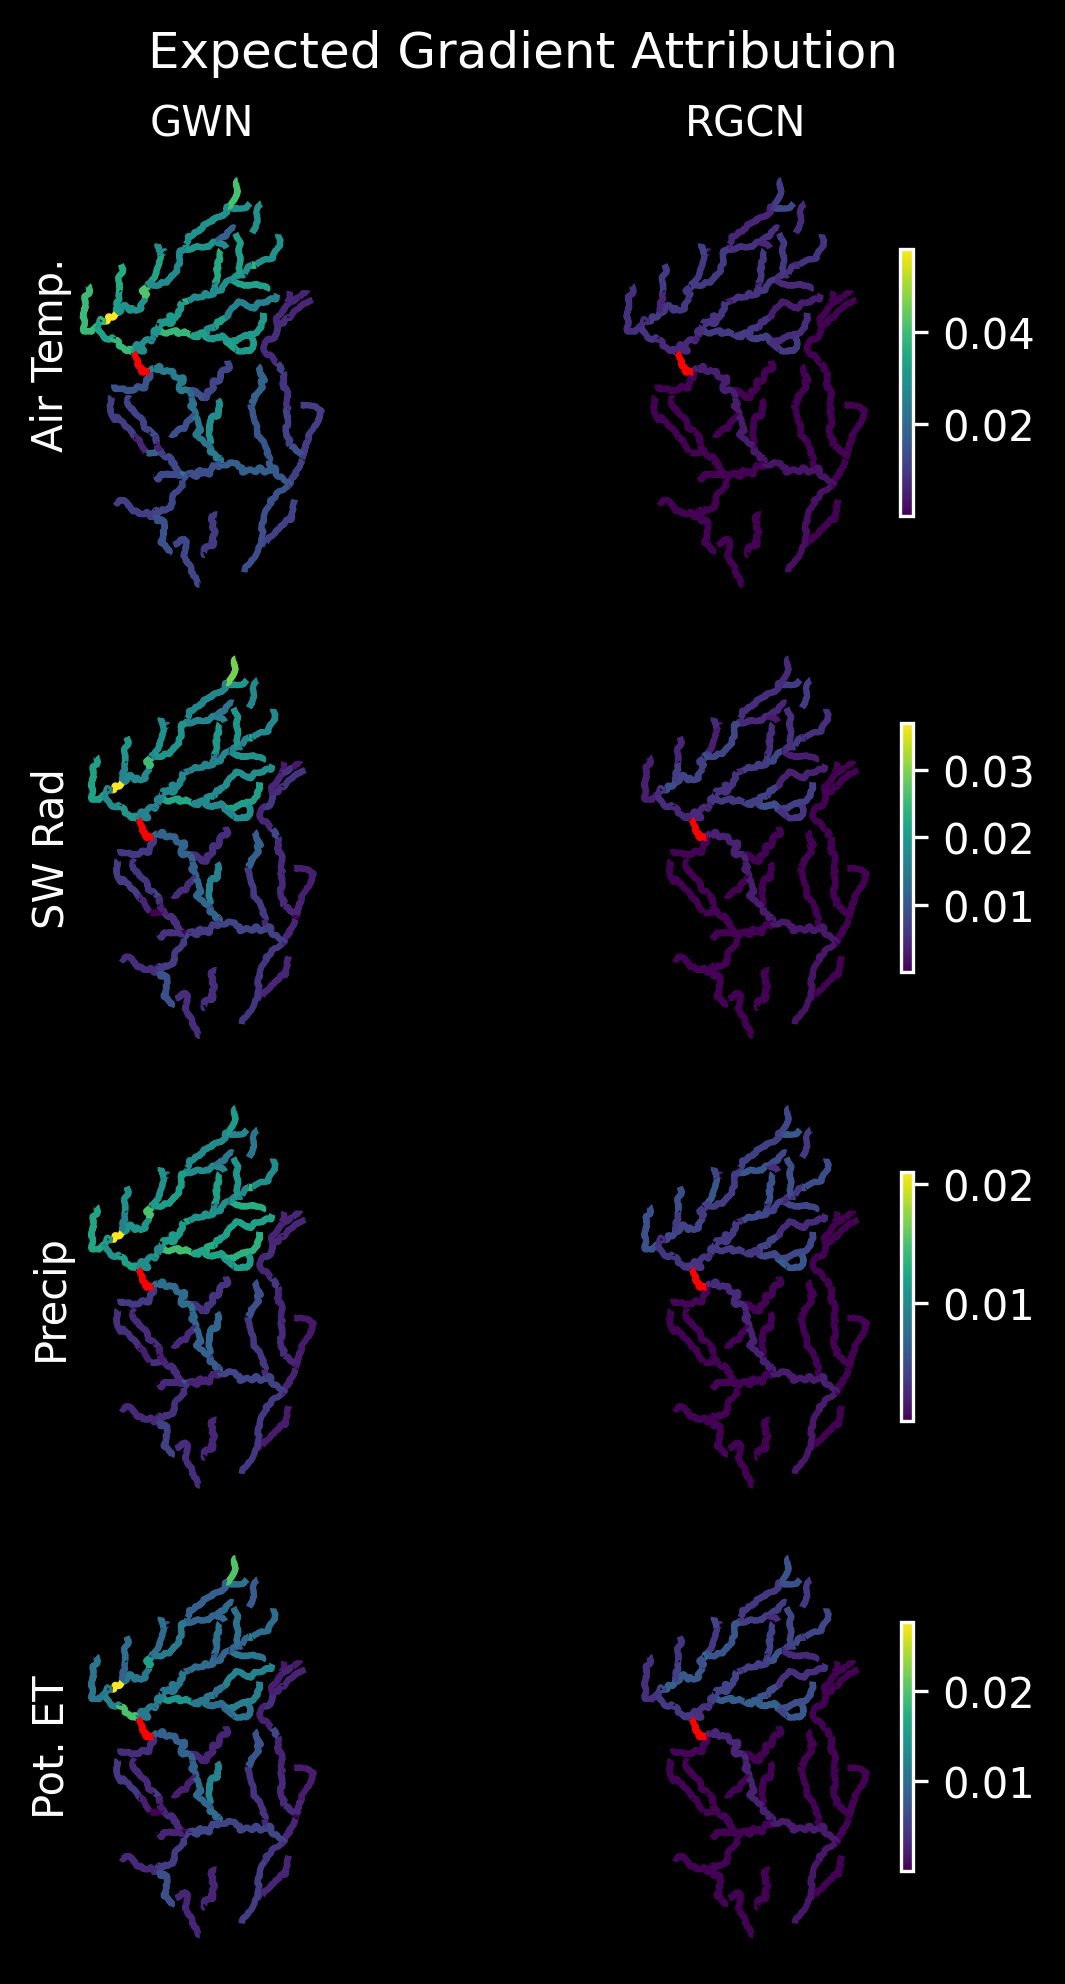

In [17]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(3.5,6.5),constrained_layout=True,dpi=300)
subfigs = fig.subfigures(4, 1, height_ratios=[1.2, 1,1,1])
labs = ['Air Temp.', 'SW Rad','Precip','Pot. ET']
roi = segs[segs.sg_d_nt == reach_id]
buff = roi.centroid.buffer(7e4)
xmin, ymin, xmax, ymax = buff.total_bounds
segs_filt= diffs_sf.cx[xmin:xmax, ymin:ymax].copy()
segs_filt.to_crs(32618)
for i in range(4):
    var = x_vars[3:][i]
    segs_filt.loc[:,var]=segs_filt.loc[:,var]*data_gwn['y_std']
    min_diff = segs_filt[var].min()
    max_diff = segs_filt[var].max()
    sub_axes = subfigs[i].subplots(1,2, gridspec_kw={'width_ratios':[1,1.2]})
    segs_filt[segs_filt.model == 'GWN'].plot(column=var, ax = sub_axes[0], vmin=min_diff,vmax=max_diff)
    roi.plot(ax=sub_axes[0],color='red')

    segs_filt[segs_filt.model == 'RGCN'].plot(column=var, ax = sub_axes[1], legend = True,vmin=min_diff,vmax=max_diff,
                                        legend_kwds={"shrink":.6})#, "format":mtick.PercentFormatter(1,1)})
    roi.plot(ax=sub_axes[1],color='red')
    sub_axes[0].set_axis_off()
    #axes[1].add_artist(ScaleBar(1,frameon=False,location='upper left',color='white'))
    sub_axes[1].set_axis_off()
    subfigs[i].text(0.03, 0.5, labs[i], va='center', rotation='vertical')
    if i ==0:
        sub_axes[0].set_title('GWN',size='medium')
        sub_axes[1].set_title('RGCN',size='medium')
fig.suptitle('Expected Gradient Attribution', size='large')
plt.savefig(f'../figures/reach_eg_contrib_full_dark.png')

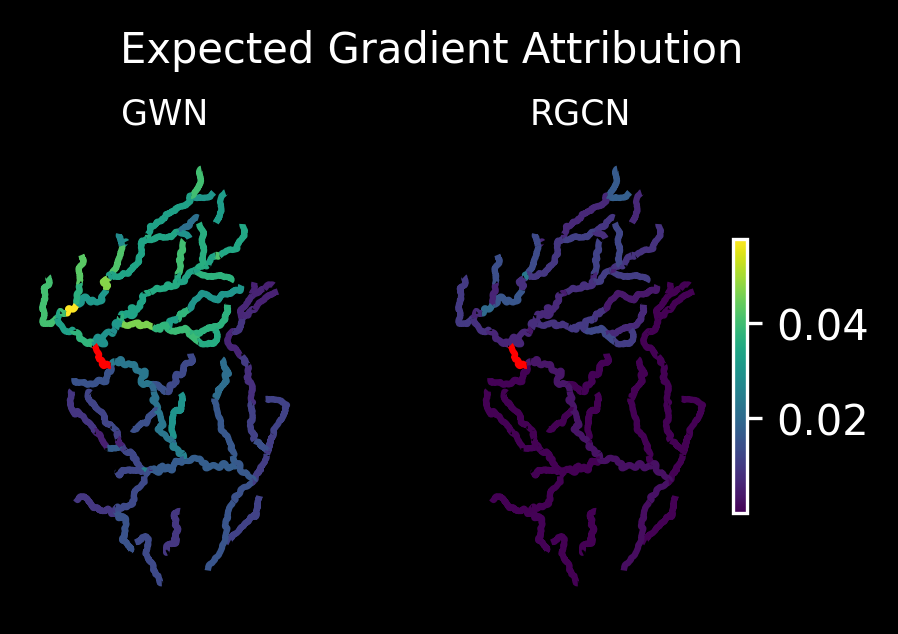

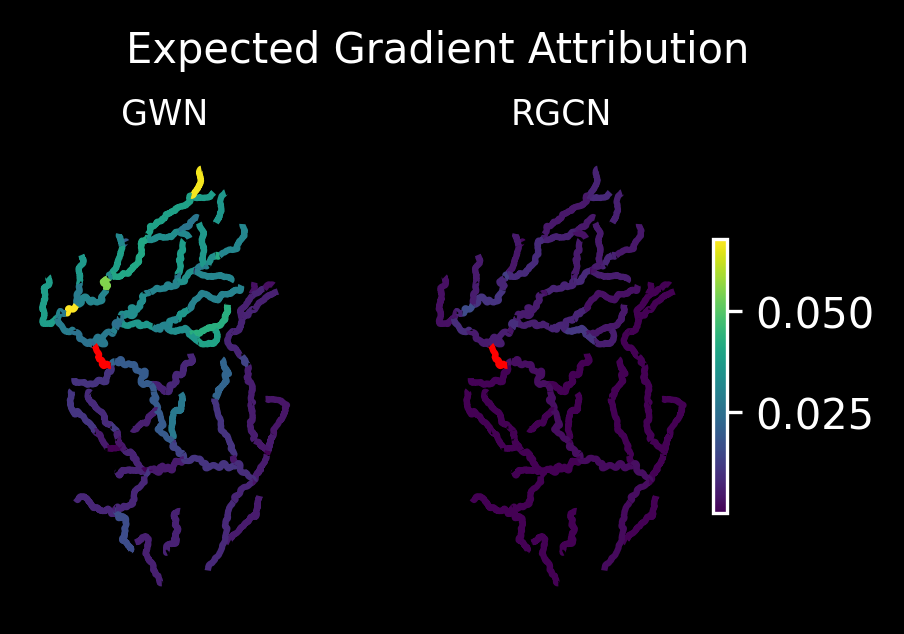

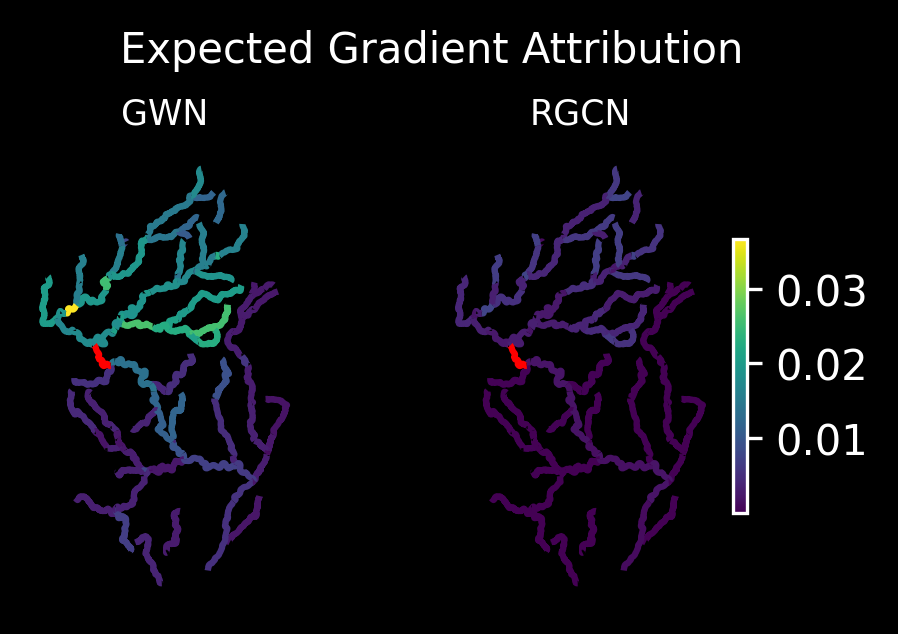

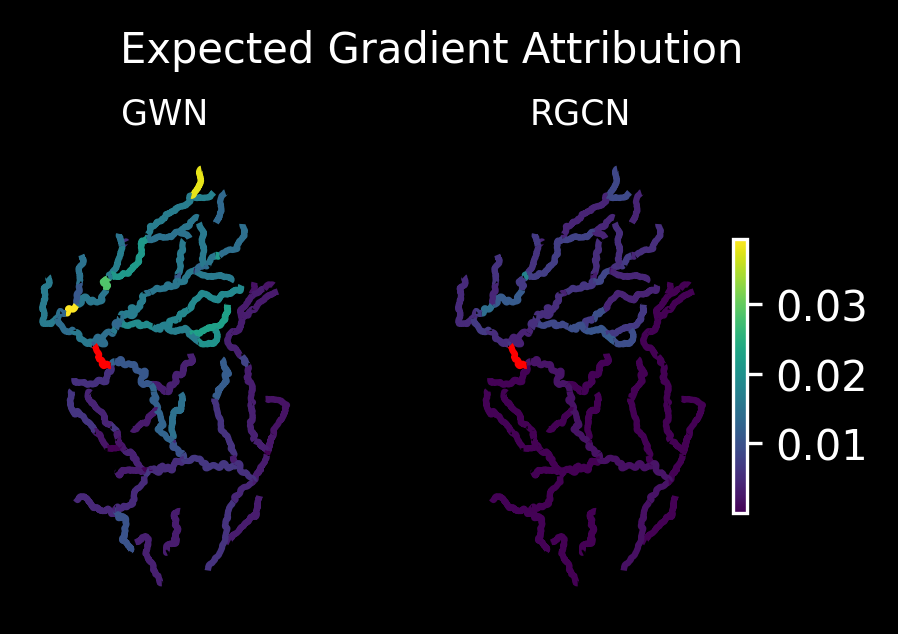

In [103]:
plt.style.use('dark_background')
var = 'seg_tave_air'
for var in x_vars[3:]:
    roi = segs[segs.sg_d_nt == reach_id]
    buff = roi.centroid.buffer(7e4)
    xmin, ymin, xmax, ymax = buff.total_bounds
    segs_filt= diffs_sf.cx[xmin:xmax, ymin:ymax].copy()
    segs_filt.to_crs(32618)
    segs_filt.loc[:,var]=segs_filt.loc[:,var]*data_gwn['y_std']
    min_diff = segs_filt[var].min()
    max_diff = segs_filt[var].max()

    fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios':[.49,.51]},figsize = (3,2),constrained_layout=True, dpi=300)
    segs_filt[segs_filt.model == 'GWN'].plot(column=var, ax = axes[0], vmin=min_diff,vmax=max_diff)
    roi.plot(ax=axes[0],color='red')

    segs_filt[segs_filt.model == 'RGCN'].plot(column=var, ax = axes[1], legend = True,vmin=min_diff,vmax=max_diff,
                                        legend_kwds={"shrink":.6})#, "format":mtick.PercentFormatter(1,1)})
    roi.plot(ax=axes[1],color='red')
    axes[0].set_axis_off()
    #axes[1].add_artist(ScaleBar(1,frameon=False,location='upper left',color='white'))
    axes[1].set_axis_off()
    axes[0].set_title('GWN',size='small')
    axes[1].set_title('RGCN',size='small')
    fig.suptitle('Expected Gradient Attribution', size='medium')
    plt.savefig(f'../figures/reach_eg_contrib_{var}_dark.png')

## Try to get high level idea of how it works seasonally

In [19]:
def seasonal_egs(model, data_in, num_rand):
    dates = data_in['times_trn']
    months = dates.astype('datetime64[M]').astype(int) % 12 + 1 #d.DatetimeIndex(river_dl['times_tst'])
    seasons = [[6,7,8],[9,10,11],[12,1,2],[3,4,5]]
    egs_months=[]
    for m in seasons:
        mask= np.isin(months[:,-1,0],m)
        batches = data_in['x_trn'][mask].shape[0]//n_segs
        rand_batch = np.random.choice(range(1,batches),num_rand,replace='False')
        egs=[]
        for i in rand_batch:
            start_ind = n_segs*i
            end_ind = n_segs*i+n_segs
            x = torch.from_numpy(data_in['x_trn'][mask]).to(device).float()[start_ind:end_ind]
            EG_vals = expected_gradients(x, 
                                    torch.from_numpy(data_in['x_trn']).to(device).float(),
                                    model, 
                                    n_samples=200, 
                                    temporal_focus=-1)
            reduced = np.mean(EG_vals,axis=0) #reduce across segments
            egs.append(reduced)
        egs_mean = np.asarray(egs).mean(axis=0) #reduce across batches
        egs_std = np.asarray(egs).std(axis=0)
        egs_months.append(np.array([egs_mean,egs_std]))
    return egs_months

In [20]:
gwn_months = seasonal_egs(gwn, data_gwn, 10)
rgcn_months = seasonal_egs(rgcn, data_rgcn, 10)

In [ ]:
for i in ['JJA','SON','DJF','MAM']:
    if i == 'JJA':
        df = pd.concat(
            pd.DataFrame(columns=x_vars,data=gwn_months[i][0]).set

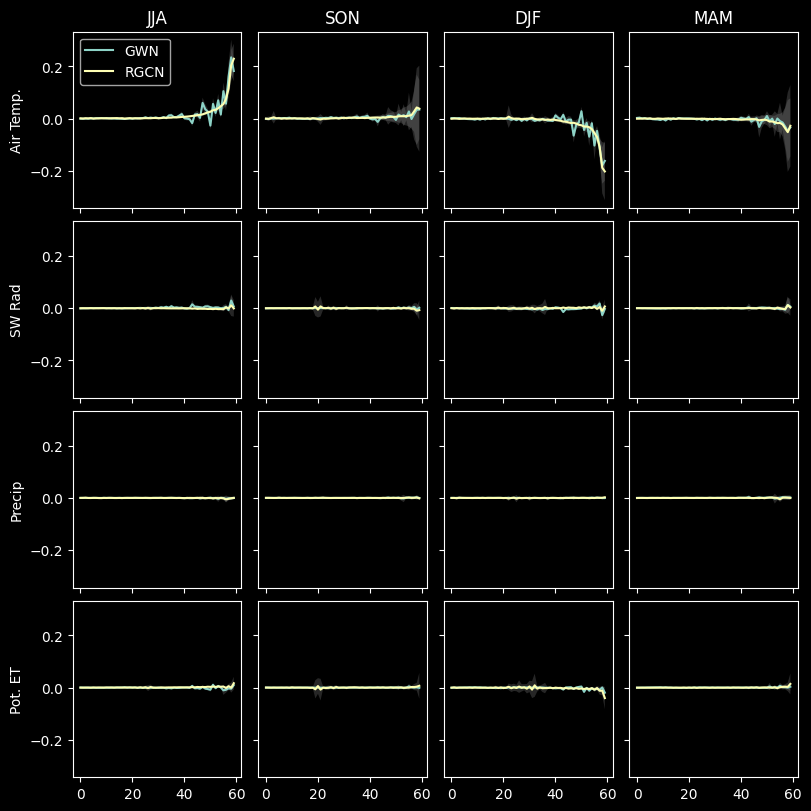

In [21]:
s=0
e=60
#labs = ['Jan-Feb','Mar-Apr','May-Jun','Jul-Aug','Sep-Oct','Nov-Dec']

labs = ['JJA','SON','DJF','MAM']
labs_vars = ['Air Temp.', 'SW Rad','Precip','Pot. ET']
fig, axes = plt.subplots(4,4,figsize = (8,8),sharex=True,sharey=True,constrained_layout=True)
for k in range(4):
    gwn_mean = gwn_months[k][0]
    gwn_sd = gwn_months[k][1]
    rgcn_mean=rgcn_months[k][0]
    rgcn_sd=rgcn_months[k][1]
    for i in range(4):
        j=i+3
        axes[i,k].plot(range(s,e),gwn_mean[-60:,j],label='GWN')
        axes[i,k].fill_between(x=range(s,e),y1=gwn_mean[-60:,j]+gwn_sd[-60:,j],y2=gwn_mean[-60:,j]-gwn_sd[-60:,j], facecolor='grey',alpha=.3)
        axes[i,k].plot(range(s,e),rgcn_mean[-60:,j],label='RGCN')
        axes[i,k].fill_between(x=range(s,e),y1=rgcn_mean[-60:,j]+rgcn_sd[-60:,j],y2=rgcn_mean[-60:,j]-rgcn_sd[-60:,j], facecolor='grey',alpha=.3)
axes[0,0].legend()
for i in range(4):
    axes[0,i].set_title(labs[i])
for i in range(4):
    axes[i,0].set_ylabel(labs_vars[i])


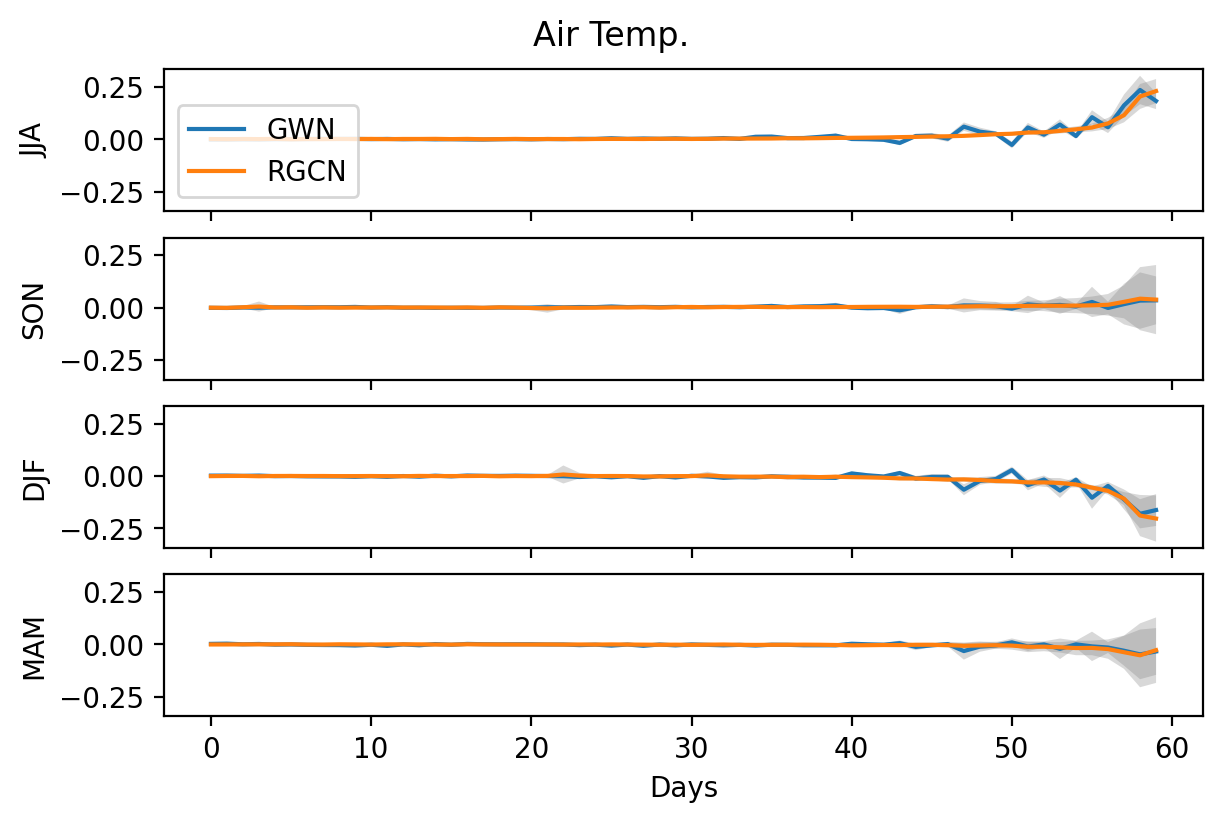

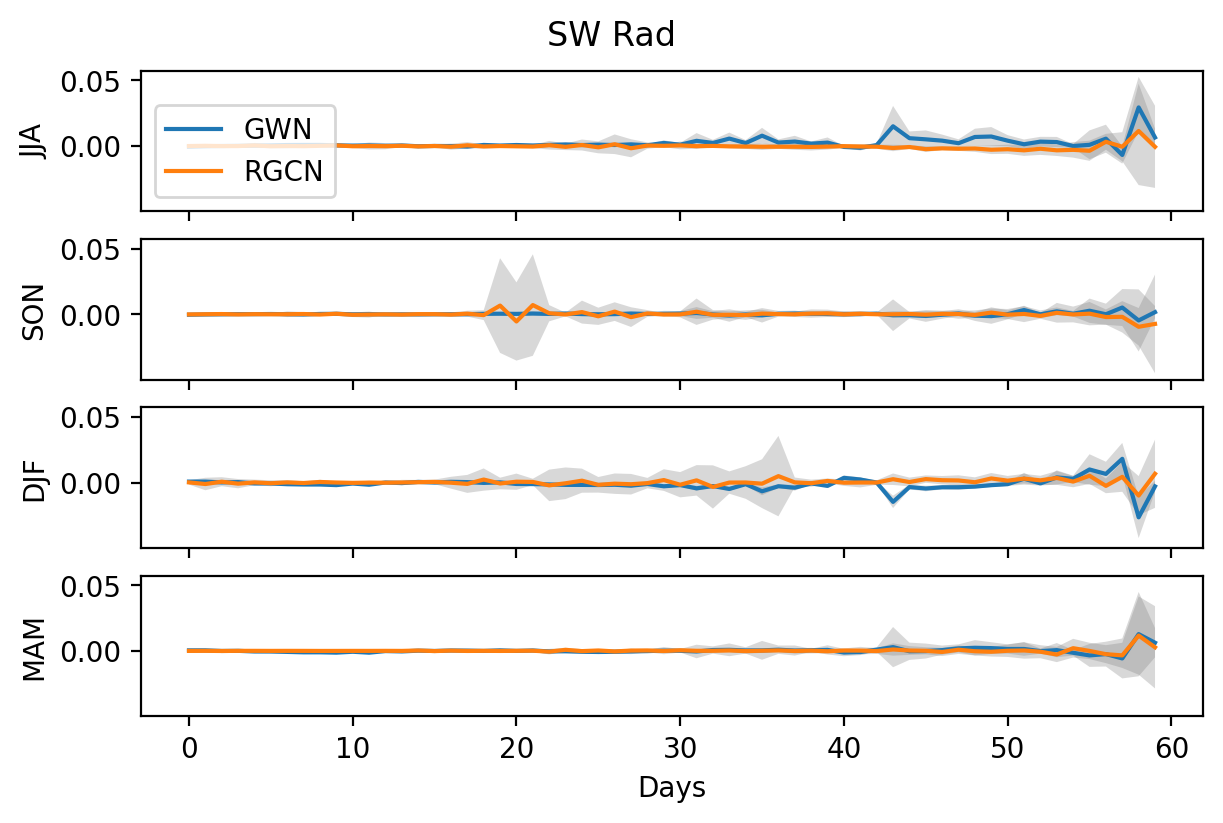

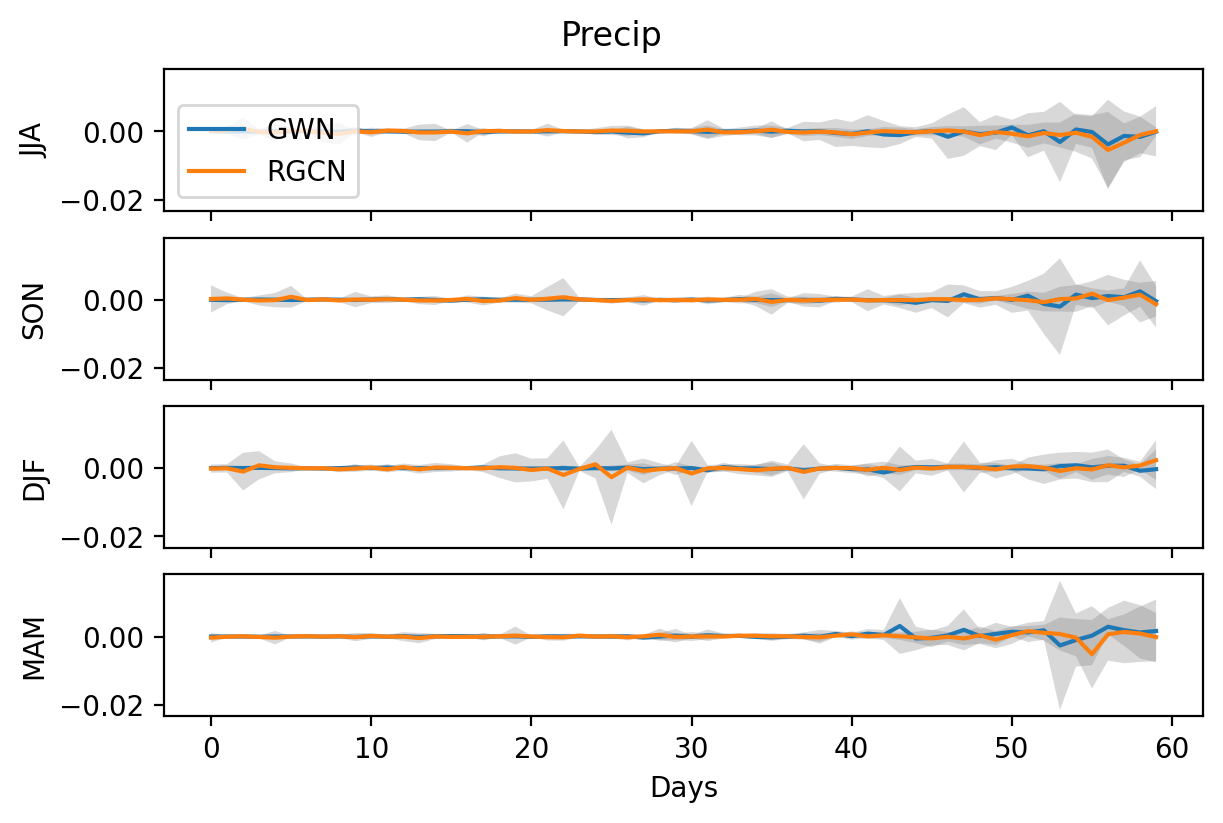

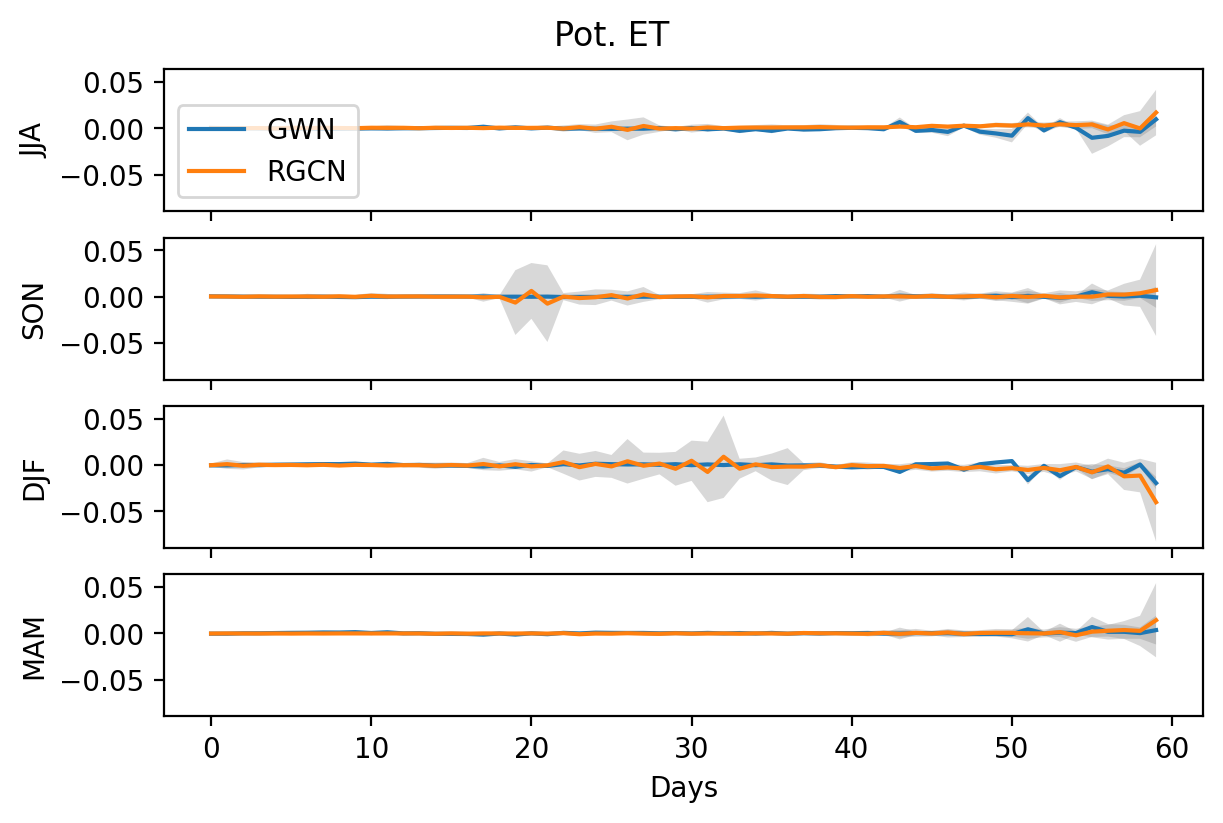

In [24]:
plt.style.use('default')
s=0
e=60
#labs = ['Jan-Feb','Mar-Apr','May-Jun','Jul-Aug','Sep-Oct','Nov-Dec']

labs = ['JJA','SON','DJF','MAM']
for i in range(4):
    fig, axes=plt.subplots(4,1,figsize = (6,4),sharex=True,sharey=True,constrained_layout=True,dpi=200)
    j=i+3
    for k in range(4):
        x=range(60)
        gwn_mean = gwn_months[k][0]
        gwn_sd = gwn_months[k][1]
        rgcn_mean=rgcn_months[k][0]
        rgcn_sd=rgcn_months[k][1]
        axes[k].plot(x,gwn_mean[-60:,j],label='GWN')
        axes[k].fill_between(x,y1=gwn_mean[-60:,j]+gwn_sd[-60:,j],y2=gwn_mean[-60:,j]-gwn_sd[-60:,j], facecolor='grey',alpha=.3)
        axes[k].plot(x,rgcn_mean[-60:,j],label='RGCN')
        axes[k].fill_between(x,y1=rgcn_mean[-60:,j]+rgcn_sd[-60:,j],y2=rgcn_mean[-60:,j]-rgcn_sd[-60:,j], facecolor='grey',alpha=.3)
        axes[k].set_ylabel(labs[k])
        axes[k].invert_xaxis()
    axes[0].legend(loc='lower left')
    axes[3].set_xlabel('Days')
    fig.suptitle(labs_vars[i])
    plt.savefig(f'../figures/seasonal_eg_contrib_{x_vars[i+3]}.png')

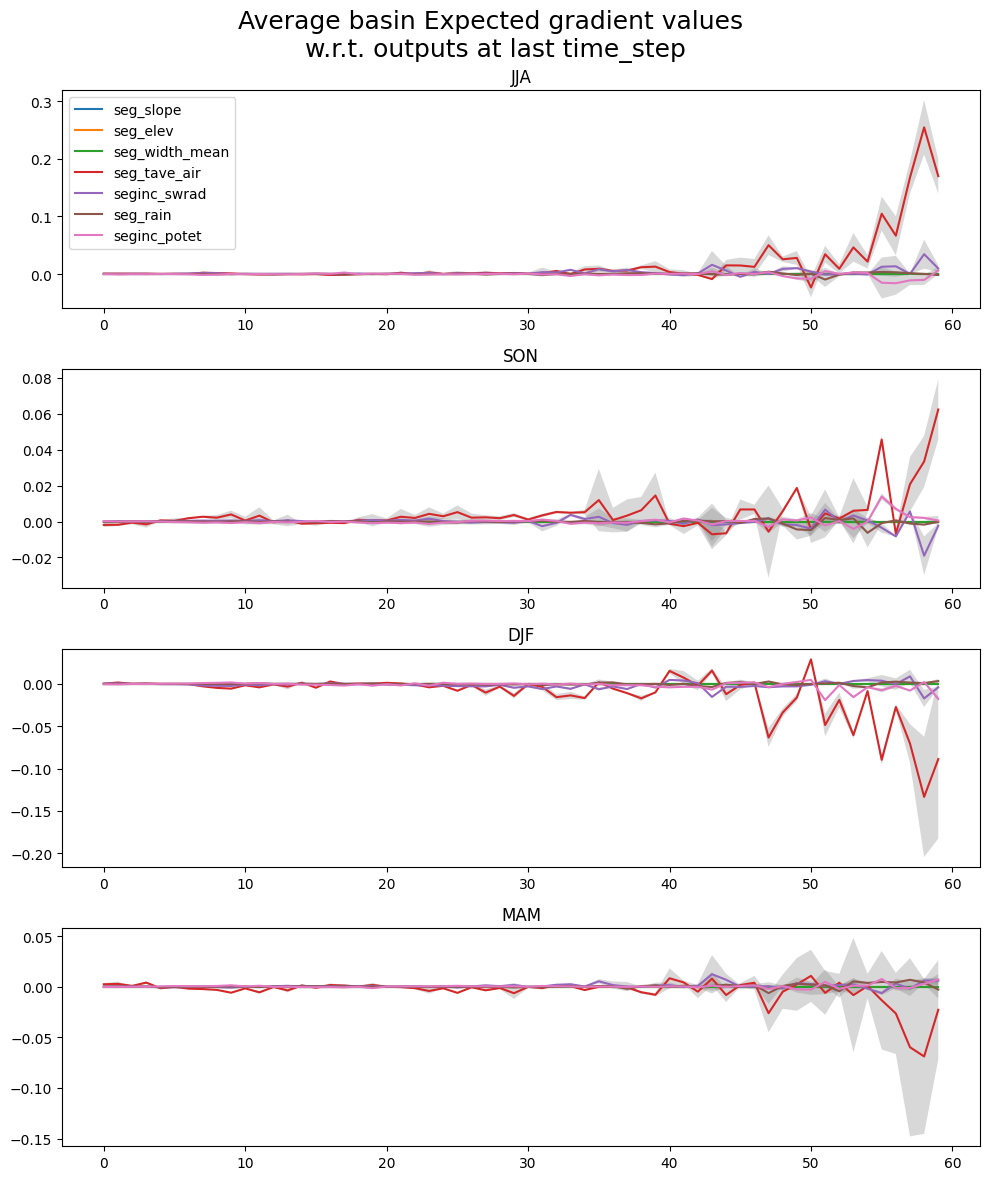

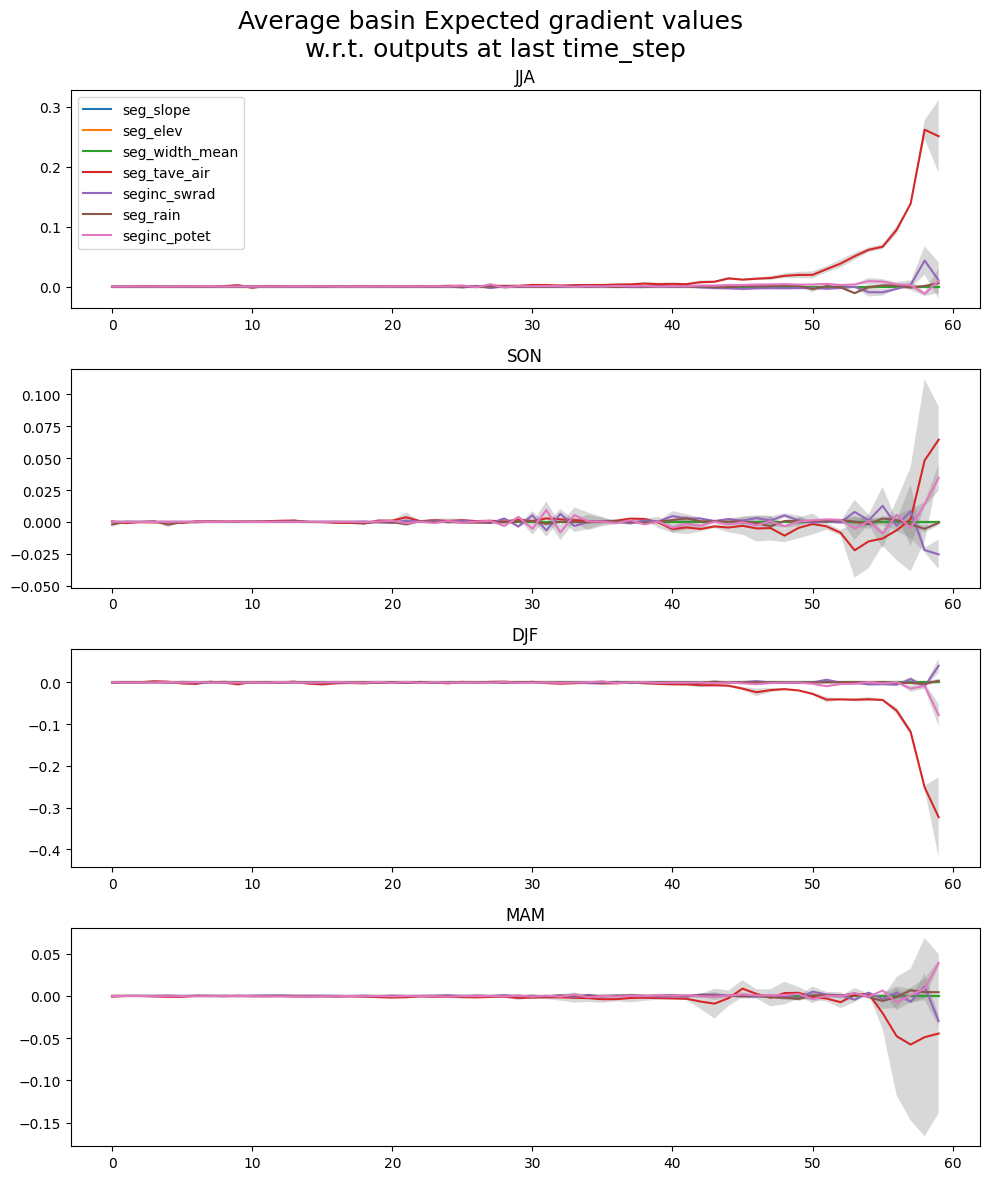

In [56]:
#egs = np.asarray(egs).mean(axis=0)
egs_months = gwn_months.copy()
for egs_months in [gwn_months,rgcn_months]:
    fig, axes = plt.subplots(nrows=len(egs_months),figsize = (10,12),tight_layout=True)
    s=0
    e=60
    #labs = ['Jan-Feb','Mar-Apr','May-Jun','Jul-Aug','Sep-Oct','Nov-Dec']
    labs = ['JJA','SON','DJF','MAM']

    for i in range(len(egs_months)):
        mean = egs_months[i][0]
        sd = egs_months[i][1]
        [axes[i].plot(range(s,e),mean[-60:,j],label=x_vars[j]) for j in range(num_vars)]
        [axes[i].fill_between(x=range(s,e),y1=mean[-60:,j]+sd[-60:,j],y2=mean[-60:,j]-sd[-60:,j], facecolor='grey',alpha=.3) for j in range(num_vars)]
        axes[i].set_title(labs[i])
        #axes[i].set_ylim(-.15,.3)
        if i == 0:
            axes[i].legend(loc = 'upper left')
        #axes[i].set_ylim(0,.4)
        #for i in range(num_vars):
        #    plt.plot(egs[:, i],label=x_vars[i])
        fig.suptitle('Average basin Expected gradient values \nw.r.t. outputs at last time_step',
              fontsize = 18);

In [4]:
def compare_temporally_altered(model, data_in, num_rand, season):
    dates = data_in['times_trn']
    months = dates.astype('datetime64[M]').astype(int) % 12 + 1 #d.DatetimeIndex(river_dl['times_tst'])
    mask= np.isin(months[:,-1,0],season)
    batches = data_in['x_trn'][mask].shape[0]//n_segs
    #seasons = [[6,7,8],[9,10,11],[12,1,2],[3,4,5]]
    #batches = data_in['x_trn'].shape[0]//n_segs
    sd_full = data_in['y_std'][0]
    rand_batch = np.random.choice(range(1,batches),num_rand,replace='False')
    data_in = torch.from_numpy(data_in['x_trn'][mask]).to(device).float()
    noised_out=[]
    for i in rand_batch:
        start_ind = n_segs*i-n_segs
        end_ind = n_segs*i
        x = data_in[start_ind:end_ind]
        y_hat_original = model(x)
        # replace first n out of 365 days with random values
        # and see how results change
        noised = []
        #seq_length = x.shape[2]
        for i in range(2,data_in.shape[1],3):
            #set_trace()
            x_hypothesis = x.detach().clone()
            x_hypothesis[:, :-i] = torch.rand_like(x[:,:-i])
            y_hat_hypothesis = model(x_hypothesis)
            diff = torch.abs(y_hat_original[:,-1]-y_hat_hypothesis[:,-1]).squeeze()
            noised.append(diff.detach().cpu().numpy().mean())    
        noised_out.append(np.asarray(noised))
    mean = np.mean(noised_out, axis=0)*sd_full
    sd = np.std(noised_out,axis=0)*sd_full
    return {"mean":mean,"sd":sd}

In [5]:

seasons=[[6,7,8],[9,10,11],[12,1,2],[3,4,5]]
gwn_temporal = [compare_temporally_altered(gwn,data_gwn,50,seas) for seas in seasons]
rgcn_temporal = [compare_temporally_altered(rgcn,data_rgcn,50,seas) for seas in seasons]

#gwn_temporal = compare_temporally_altered(gwn, data_gwn,10,seasons[3])
#rgcn_temporal = compare_temporally_altered(rgcn, data_rgcn,10,seasons[3])

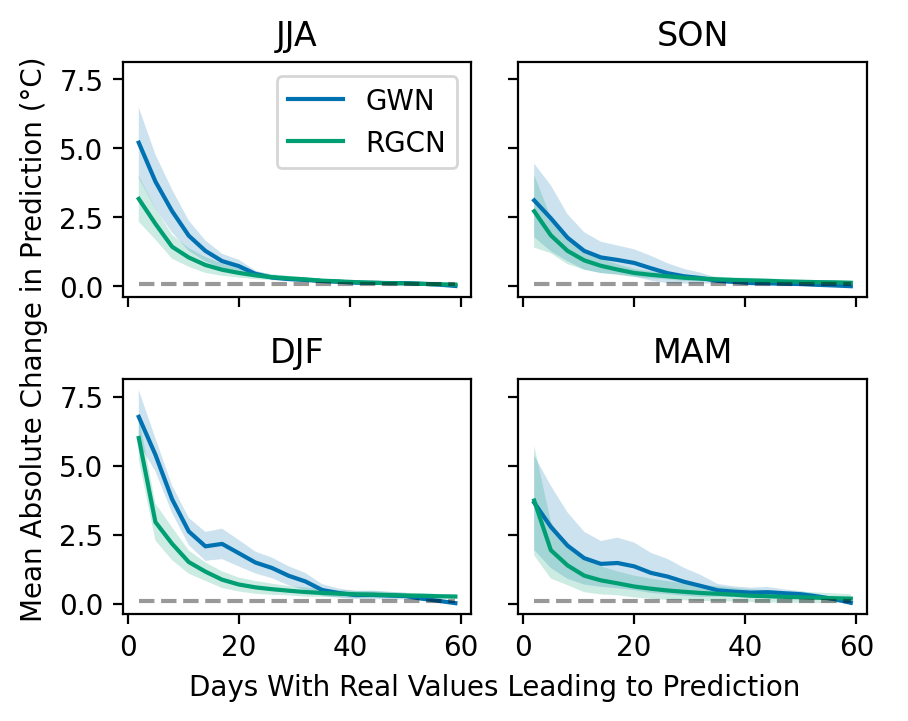

In [24]:
#fig = plt.figure()
labs = ['JJA','SON','DJF','MAM']
plt.style.use('default')
plt.style.use('seaborn-colorblind')
#x1=np.linspace(2,180,len(rgcn_temporal['mean']))#range(2,180,3)
#x2=np.linspace(0,60,len(gwn_temporal['mean']))#range(2,60,3)
x2=range(2,60,3)
#x1= x1[::-1]
#x2= x2[::-1]
fig, ax = plt.subplots(2,2,figsize=(5,4),dpi=200,sharex=True,sharey=True,tight_layout=True)

#plt.ylabel('top',loc='top')

for i in range(4):
    ax.ravel()[i].fill_between(x2,
                     gwn_temporal[i]['mean']-gwn_temporal[i]['sd'],
                     gwn_temporal[i]['mean']+gwn_temporal[i]['sd'],
                     alpha=.2)
    ax.ravel()[i].plot(x2,gwn_temporal[i]['mean'],label='GWN')
    ax.ravel()[i].fill_between(x2,
                     rgcn_temporal[i]['mean'][:20]-rgcn_temporal[i]['sd'][:20],
                     rgcn_temporal[i]['mean'][:20]+rgcn_temporal[i]['sd'][:20],
                     alpha=.2)
    ax.ravel()[i].plot(x2,rgcn_temporal[i]['mean'][:20],label='RGCN')
    ax.ravel()[i].plot(x2,np.repeat(.1,len(x2)),color = 'black', linestyle ='--',alpha=.4)
    #ax.ravel()[i].set_xlabel('Days With Real Values Leading to Prediction')
    #ax.ravel()[i].set_ylabel('Mean Change in Prediction °C')
    ax.ravel()[i].set_title(labs[i])
    if i == 0:
        ax.ravel()[i].legend(loc='upper right')
        #ax.ravel()[i].invert_xaxis()
        #ax.ravel()[i].set_xticks(range(1,70,10), range(60,-10,-10))  # Set text labels and properties.
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Days With Real Values Leading to Prediction')
plt.ylabel('Mean Absolute Change in Prediction (°C)')
        #ax.ravel()[1].set_ylabel('Mean Change in Prediction °C')
plt.savefig(f'../figures/time_noise_seasonal.png')

In [112]:
len(gwn_temporal['mean'])

20

In [29]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

Signature: plt.get_cmap(name=None, lut=None)
Docstring:
Get a colormap instance, defaulting to rc values if *name* is None.

Colormaps added with :func:`register_cmap` take precedence over
built-in colormaps.

Notes
-----
Currently, this returns the global colormap object, which is deprecated.
In Matplotlib 3.5, you will no longer be able to modify the global
colormaps in-place.

Parameters
----------
name : `matplotlib.colors.Colormap` or str or None, default: None
    If a `.Colormap` instance, it will be returned. Otherwise, the name of
    a colormap known to Matplotlib, which will be resampled by *lut*. The
    default, None, means :rc:`image.cmap`.
lut : int or None, default: None
    If *name* is not already a Colormap instance and *lut* is not None, the
    colormap will be resampled to have *lut* entries in the lookup table.
File:      ~/miniconda3/envs/torch_xai/lib/python3.9/site-packages/matplotlib/cm.py
Type:      function


In [4]:
def reformat_prepped(prepped,seq_len,partition='tst'):
    x_data = prepped[f'x_{partition}'][:,-seq_len:,:]
    shape_x = x_data.shape
    x_data = x_data.reshape(shape_x[0]*shape_x[1],shape_x[2])
    x_data = x_data*prepped['x_std']+prepped['x_mean']
    dates= prepped[f'times_{partition}'][:,-90:,:].reshape(shape_x[0]*shape_x[1])
    df = pd.DataFrame(columns=x_vars, data=x_data)
    df['date']=pd.to_datetime(dates)
    df['month']=df['date'].dt.month
    return df

In [5]:
##Look at baseline distributions
baseline_prepped = np.load(f"../../river-dl/results/baseline/RGCN/prepped.npz")
x_vars = baseline_prepped['x_vars']
baseline_trn = reformat_prepped(np.load(f"../../river-dl/results/baseline/RGCN/prepped.npz"),90,'trn')
baseline_tst = reformat_prepped(np.load(f"../../river-dl/results/baseline/RGCN/prepped.npz"),90,'tst')

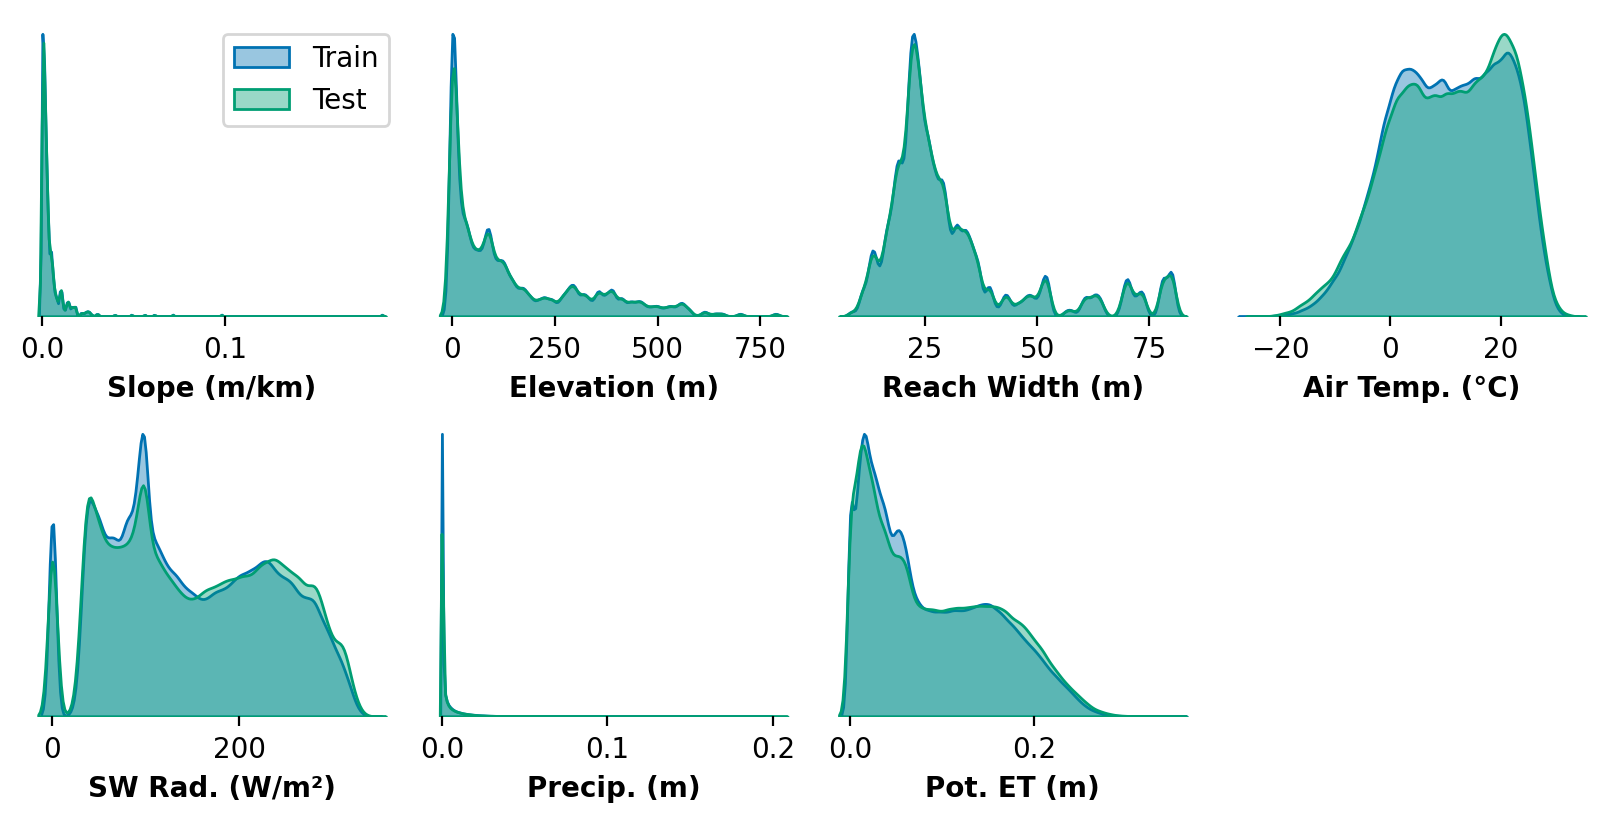

In [11]:
plt.style.use('default')
plt.style.use('seaborn-colorblind')
labs=np.array(['Slope (m/km)','Elevation (m)','Reach Width (m)','Air Temp. (°C)', 'SW Rad. (W/m\u00b2)', 'Precip. (m)', 'Pot. ET (m)'])
fig, axes = plt.subplots(2,4, figsize =(8,4), dpi=200,constrained_layout=True)
for i in range(7):
    sns.kdeplot(baseline_trn[x_vars[i]],ax=axes.ravel()[i],label = 'Train', alpha=.4, fill=True)
    sns.kdeplot(baseline_tst[x_vars[i]],ax=axes.ravel()[i],label = 'Test', alpha=.4,fill=True)
    axes.ravel()[i].set_xlabel(labs[i],fontweight='bold')
    axes.ravel()[i].set_ylabel('')
    axes.ravel()[i].axes.yaxis.set_visible(False)
    axes.ravel()[i].set_frame_on(False)
axes.ravel()[-1].set_axis_off()
axes.ravel()[0].legend(loc='upper right')
axes.ravel()[0].set_ylabel('Density')
axes.ravel()[4].set_ylabel('Density')

plt.savefig('figures/baseline_input_distributions.png',dpi=200)

In [26]:
baseline = reformat_prepped(data_rgcn,90)
lto_max = reformat_prepped(np.load(f"../../river-dl/results/LTO/RGCN/max/prepped.npz"),90)
lto_min = reformat_prepped(np.load(f"../../river-dl/results/LTO/RGCN/min/prepped.npz"),90)
drought = reformat_prepped(np.load(f"../../river-dl/results/Drought/RGCN/prepped.npz"),90)

baseline_trn = reformat_prepped(data_rgcn,90,'trn')
lto_max_trn = reformat_prepped(np.load(f"../../river-dl/results/LTO/RGCN/max/prepped.npz"),90,'trn')
lto_min_trn = reformat_prepped(np.load(f"../../river-dl/results/LTO/RGCN/min/prepped.npz"),90,'trn')
drought_trn = reformat_prepped(np.load(f"../../river-dl/results/Drought/RGCN/prepped.npz"),90,'trn')

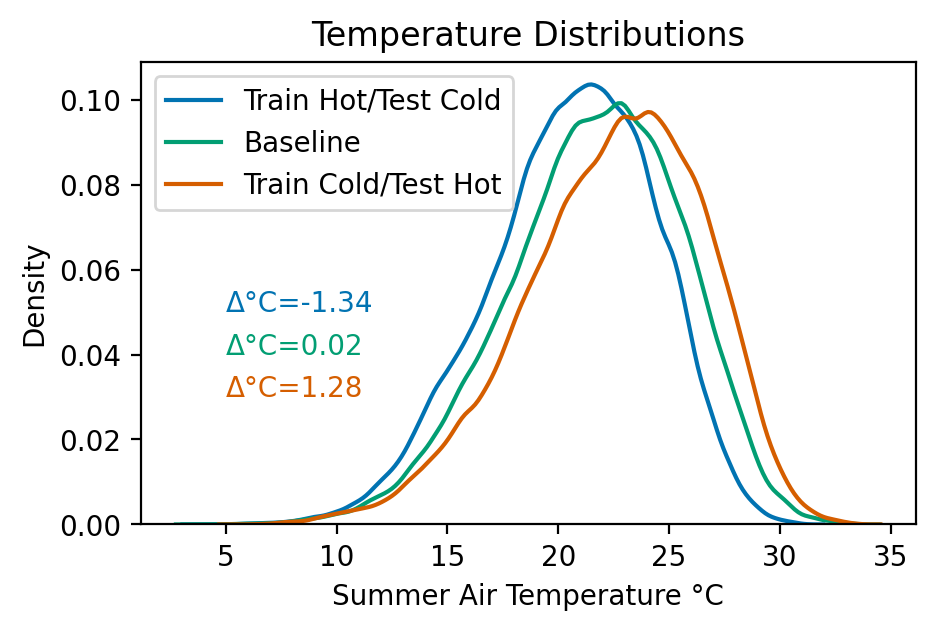

In [31]:
#plt.style.use('default')
plt.style.use('seaborn-colorblind')
def calc_diff(tst,trn):
    return tst['seg_tave_air'][tst.month.isin([6,7,8])].median()-trn['seg_tave_air'][trn.month.isin([6,7,8])].median()
base_diff = calc_diff(baseline,baseline_trn)
max_diff= calc_diff(lto_max,lto_max_trn)
min_diff = calc_diff(lto_min,lto_min_trn)

pal = list(sns.color_palette('colorblind',4))

fig, ax = plt.subplots(figsize=(5,3),dpi=200)
sns.kdeplot(lto_min['seg_tave_air'][lto_min.month.isin([6,7,8])],ax=ax,label=f'Train Hot/Test Cold',color = pal[0])
sns.kdeplot(baseline['seg_tave_air'][baseline.month.isin([6,7,8])],ax=ax,label=f'Baseline',color = pal[2])
sns.kdeplot(lto_max['seg_tave_air'][lto_max.month.isin([6,7,8])],ax=ax,label=f'Train Cold/Test Hot',color = pal[3])
#sns.kdeplot(lto_max_trn['seg_tave_air'][lto_max_trn.month.isin([6,7,8])],ax=ax,label='Train Cold/Test Hot',linestyle="--")
ax.set_xlabel('Summer Air Temperature °C')
ax.set_title('Temperature Distributions')
ax.annotate(f'Δ°C={base_diff:.2f}', xy=(5,.04),color = pal[2])
ax.annotate(f'Δ°C={max_diff:.2f}', xy=(5,.03),color = pal[3])
ax.annotate(f'Δ°C={min_diff:.2f}', xy=(5,.05),color = pal[0])

ax.legend()
plt.savefig('../figures/temp_distributions.png',dpi=200)

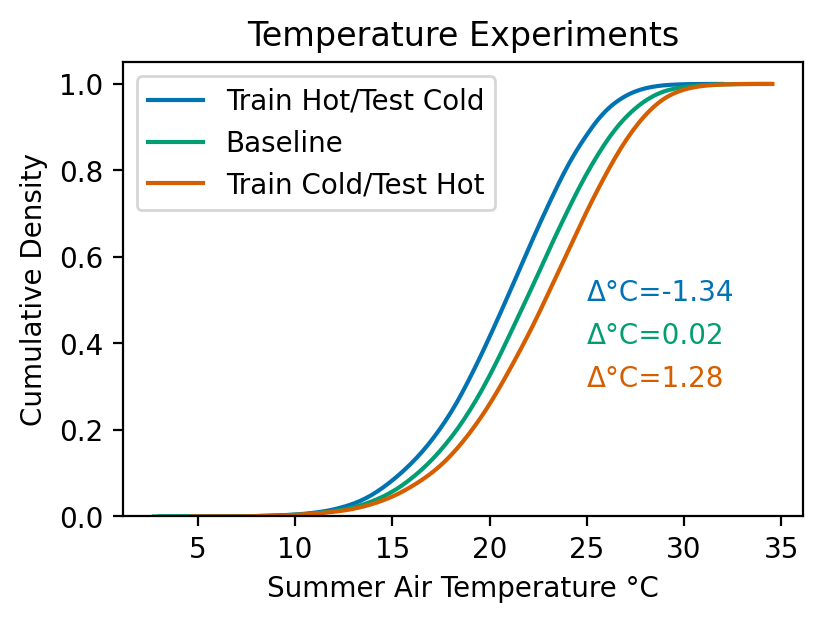

In [34]:
#plt.style.use('default')
plt.style.use('seaborn-colorblind')
def calc_diff(tst,trn):
    return tst['seg_tave_air'][tst.month.isin([6,7,8])].median()-trn['seg_tave_air'][trn.month.isin([6,7,8])].median()
base_diff = calc_diff(baseline,baseline_trn)
max_diff= calc_diff(lto_max,lto_max_trn)
min_diff = calc_diff(lto_min,lto_min_trn)

pal = list(sns.color_palette('colorblind',4))

fig, ax = plt.subplots(figsize=(4,3),dpi=200,constrained_layout=True)
sns.kdeplot(lto_min['seg_tave_air'][lto_min.month.isin([6,7,8])],ax=ax,cumulative=True,label=f'Train Hot/Test Cold',color = pal[0])
sns.kdeplot(baseline['seg_tave_air'][baseline.month.isin([6,7,8])],ax=ax,cumulative=True,label=f'Baseline',color = pal[2])
sns.kdeplot(lto_max['seg_tave_air'][lto_max.month.isin([6,7,8])],ax=ax,cumulative=True,label=f'Train Cold/Test Hot',color = pal[3])
#sns.kdeplot(lto_max_trn['seg_tave_air'][lto_max_trn.month.isin([6,7,8])],ax=ax,label='Train Cold/Test Hot',linestyle="--")
ax.set_xlabel('Summer Air Temperature °C')
ax.set_ylabel('Cumulative Density')
ax.set_title('Temperature Experiments')

ax.annotate(f'Δ°C={max_diff:.2f}', xy=(25,.3),color = pal[3])
ax.annotate(f'Δ°C={base_diff:.2f}', xy=(25,.4),color = pal[2])
ax.annotate(f'Δ°C={min_diff:.2f}', xy=(25,.5),color = pal[0])

ax.legend()
plt.savefig('../figures/temp_cum_distributions.png',dpi=200)

In [35]:
baseline['run']='Baseline'
drought['run']='Train Wet/Test Dry (Drought)'
drought_df = pd.concat([baseline,drought],ignore_index=True)
drought_df['year']=drought_df.date.dt.year
drought_df = drought_df.groupby(['run','year','date']).mean().groupby(['run','year']).sum()

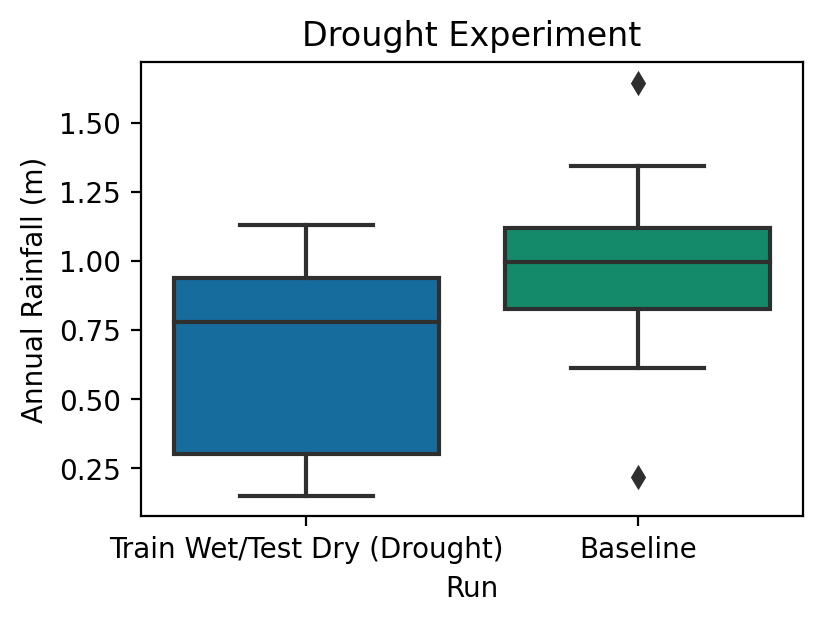

In [36]:
#plt.style.use('seaborn-colorblind')
def calc_diff(tst,trn):
    return tst['seg_rain'].median()-trn['seg_rain'].median()
base_diff = calc_diff(baseline,baseline_trn)
drought_diff = calc_diff(drought, drought_trn)

fig, ax = plt.subplots(figsize=(4,3),dpi=200,constrained_layout=True)
sns.boxplot(data=drought_df.reset_index(), x='run', y='seg_rain',ax=ax,order=['Train Wet/Test Dry (Drought)','Baseline'])#,label=f'Drought',color = pal[0])
ax.set_ylabel('Annual Rainfall (m)')
ax.set_xlabel('Run')
ax.set_title('Drought Experiment')

plt.savefig('../figures/precip_distributions.png',dpi=200)

In [50]:
drought_df.head()

seg_slope     seg_elev  seg_width_mean  seg_tave_air  \
run      year                                                          
baseline 1980  620.495748  18604006.32    3.912855e+06  1.704348e+06   
         1981  820.583145  24603124.30    5.174609e+06  1.651428e+06   
         1982  820.583145  24603124.30    5.174609e+06  1.646925e+06   
         1983  820.583145  24603124.30    5.174609e+06  1.743088e+06   
         1984  615.999402  18469194.68    3.884501e+06  1.396697e+06   

               seginc_swrad    seg_rain  seginc_potet    month  
run      year                                                   
baseline 1980  2.097000e+07  314.615007  13610.470554  1003275  
         1981  2.421860e+07  447.255098  14343.793464  1083810  
         1982  2.372658e+07  453.360165  13998.889743  1083810  
         1983  2.508807e+07  610.793166  15093.570735  1083810  
         1984  1.961470e+07  438.788897  11854.180661   624260

In [103]:
def calc_feature_importance(model, data_in, num_rand):
    batches = data_in['x_trn'].shape[0]//n_segs
    rand_batch = np.random.choice(range(1,batches),num_rand,replace='False')

    egs = []
    mse_ls=[]
    x_full = torch.from_numpy(data_in['x_trn']).to(device).float()
    var_sample = torch.randperm(x_full.shape[0])[:2000]
    var_sample = x_full[var_sample]
    for i in rand_batch:
        start_ind = n_segs*i-n_segs
        end_ind = n_segs*i
        x = x_full[start_ind:end_ind]
        EG_vals = expected_gradients(x, 
                                     x_full,#torch.from_numpy(data_in['x_trn']).to(device).float(),
                                     model, 
                                     n_samples=200,temporal_focus=-1)
        EG_vals=np.abs(EG_vals)
        #Sum across reaches and timesteps
        EG_vals = np.sum(EG_vals,axis=0).sum(axis=0)
        egs.append(EG_vals)
        mse_batch = []
        for var in range(len(x_vars)):
            #set_trace()
            x_hypothesis = x.detach().clone()
            var_range = torch.quantile(var_sample[:,:,var].flatten(),torch.tensor([.25,.75]).to(device))
            #var_min = torch.min(x[:,:,var])
            #var_max=torch.max(x[:,:,var])
            #Make random distribution within the range of the target variable
            x_hypothesis[:, :, var] = (var_range[0]-var_range[1])*torch.rand_like(x_hypothesis[:, :, var])+var_range[1]
            original_y_hat = model(x)[:,-1,:]
            y_hypothesis = model(x_hypothesis)[:,-1,:]
            mse = torch.mean((y_hypothesis.detach() - original_y_hat.detach())**2).item()
            mse_batch.append(mse*data_in['y_std'][0])
        mse_ls.append(mse_batch)
    return {'mse':mse_ls,'egs':egs}


In [104]:
gwn_fi = calc_feature_importance(gwn, data_gwn, 30)
rgcn_fi = calc_feature_importance(rgcn, data_rgcn, 30)

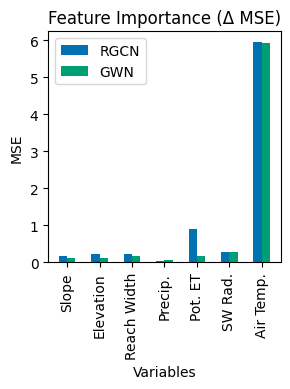

In [144]:
plt.style.use('default')
plt.style.use('seaborn-colorblind')
egs_rgcn = np.asarray(rgcn_fi['egs']).mean(axis=0)
mse_rgcn = np.asarray(rgcn_fi['mse']).mean(axis=0)
ordered_importance_of_vars_r = np.argsort(egs_rgcn)
labs= np.array(['Slope','Elevation','Reach Width','Air Temp.', 'SW Rad.', 'Precip.', 'Pot. ET'])

egs_gwn = np.asarray(gwn_fi['egs']).mean(axis=0)
mse_gwn = np.asarray(gwn_fi['mse']).mean(axis=0)
ordered_importance_of_vars_g = np.argsort(egs_gwn)

labs= np.array(['Slope','Elevation','Reach Width','Air Temp.', 'SW Rad.', 'Precip.', 'Pot. ET'])
plt.figure(figsize=(3,3))
#plt.scatter(range(len(mse)),mse_rgcn[ordered_importance_of_vars_r],label='RGCN')
#plt.scatter(range(len(mse)),mse_gwn[ordered_importance_of_vars_r],label='GWN')
# Width of a bar 
width = .3   
# Plotting
plt.bar(np.linspace(0,len(mse),len(mse))-width/2,mse_rgcn[ordered_importance_of_vars_g],width,label='RGCN')
plt.bar(np.linspace(0,len(mse),len(mse))+width/2,mse_gwn[ordered_importance_of_vars_g],width,label='GWN')
plt.xticks(np.linspace(0,len(mse),len(mse)), labels = labs[ordered_importance_of_vars_g], rotation = 90)
plt.title('Feature Importance (Δ MSE)')
plt.legend(loc='upper left')
plt.ylabel('MSE')
plt.xlabel("Variables");
plt.savefig('../figures/feature_imp.png',dpi=200)

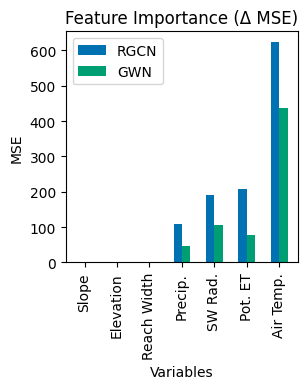

In [145]:
labs= np.array(['Slope','Elevation','Reach Width','Air Temp.', 'SW Rad.', 'Precip.', 'Pot. ET'])
plt.figure(figsize=(3,3))
#plt.scatter(range(len(mse)),mse_rgcn[ordered_importance_of_vars_r],label='RGCN')
#plt.scatter(range(len(mse)),mse_gwn[ordered_importance_of_vars_r],label='GWN')
# Width of a bar 
width = .3   
# Plotting
plt.bar(np.linspace(0,len(mse),len(mse))-width/2,egs_rgcn[ordered_importance_of_vars_r],width,label='RGCN')
plt.bar(np.linspace(0,len(mse),len(mse))+width/2,egs_gwn[ordered_importance_of_vars_r],width,label='GWN')
plt.xticks(np.linspace(0,len(mse),len(mse)), labels = labs[ordered_importance_of_vars_r], rotation = 90)
plt.title('Feature Importance (Δ MSE)')
plt.legend(loc='upper left')
plt.ylabel('MSE')
plt.xlabel("Variables");
plt.savefig('../figures/feature_imp_EG.png',dpi=200)